In [53]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

# Old model for keras, need to update to tensorflow 2
# from __future__ import print_function
# import keras
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Conv2D, MaxPooling2D
# from keras import backend as K

# New tensorflow 2 model
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Params
batch_size = 128
num_classes = 10
epochs = 12
learning_rate = 0.001
drop_out = 0.2
img_rows, img_cols = 28, 28

mnist = tf.keras.datasets.mnist
# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [54]:

### OLD ###
# # # originally needed to differentiate versions of the dataset being pulled
# if K.image_data_format() == 'channels_first':
#     x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#     x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)

### NEW Reference ###
# https://www.tensorflow.org/tutorials/quickstart/advanced


# convert to float32 in range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

### OLD ###
# # convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

### OLD ###
# Will not be using CNN in Numpy, so will put a pin in this model until later
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

### NEW ###
# two layers and will add a softmax activation at the end (not in model)
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(img_rows, img_cols)),
  tf.keras.layers.Dense(batch_size, activation='relu'),
  tf.keras.layers.Dropout(drop_out),
  tf.keras.layers.Dense(num_classes)
])

### NEW ###
# Now handled with 'SparseCategoricalCrossentropy', basically a ohe for tf2
# So define the loss function as: 
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=epochs)

score = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
Epoch 1/12
1875/1875 [==============================] - 2s 912us/step - loss: 0.2989 - accuracy: 0.9140
Epoch 2/12
1875/1875 [==============================] - 2s 900us/step - loss: 0.1428 - accuracy: 0.9578
Epoch 3/12
1875/1875 [==============================] - 2s 908us/step - loss: 0.1100 - accuracy: 0.9665
Epoch 4/12
1875/1875 [==============================] - 2s 911us/step - loss: 0.0899 - accuracy: 0.9720
Epoch 5/12
1875/1875 [==============================] - 2s 919us/step - loss: 0.0751 - accuracy: 0.9761
Epoch 6/12
1875/1875 [==============================] - 2s 903us/step - loss: 0.0658 - accuracy: 0.9793
Epoch 7/12
1875/1875 [==============================] - 2s 901us/step - loss: 0.0599 - accuracy: 0.9814
Epoch 8/12
1875/1875 [==============================] - 2s 908us/step - loss: 0.0533 - accuracy: 0.9829
Epoch 9/12
1875/1875 [==============================] - 2s 905us/step - loss: 0.0479 - accuracy: 0

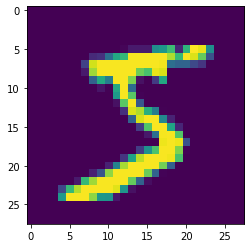

In [52]:
plt.imshow(X_train[:1].reshape(28,28))

In [21]:
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)
import time

# PyTorch model
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

class ModelNet(torch.nn.Module):
  def __init__(self):
    super(ModelNet, self).__init__()
    self.l1 = nn.Linear(img_rows * img_cols, batch_size, bias=False)
    self.l2 = nn.Linear(batch_size, num_classes, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x

# use GPU if availible
# dev = "cpu"
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

Using cuda:0 for calucations
loss 0.23 accuracy 0.92: 100%|██████████| 1000/1000 [00:07<00:00, 136.05it/s]


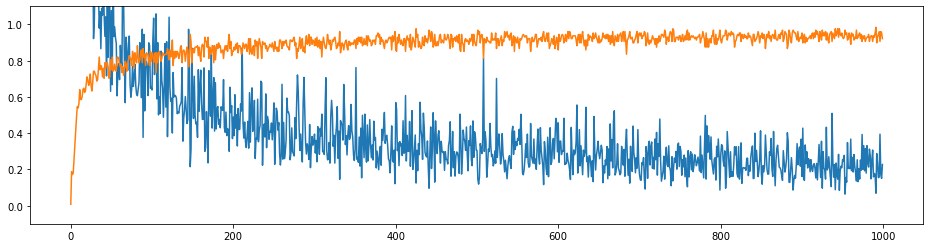

In [22]:
# training

print(f"Using {dev} for calucations")
if dev != "cpu":
  model = ModelNet()
  model.to(torch.device("cuda:0"))
else:
  model = ModelNet()
time.sleep(1)

"""
with torch.no_grad():
  model.l1.weight.copy_(torch.tensor(layer_init(784, 128).T))
  model.l2.weight.copy_(torch.tensor(layer_init(128, 10).T))
"""

loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

losses, accuracies = [], []

for i in (t := trange(1000)):   # walrus here is tqdm trick
  
  samp = np.random.randint(0, X_train.shape[0], size=(batch_size))

  # Convert to cpu in case on gpu
  X = torch.tensor(X_train[samp].reshape((-1, img_rows * img_cols)).float().to(dev)
  Y = torch.tensor(y_train[samp]).long().to(dev)

  model.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss = loss.mean()
  loss.backward()
  optim.step()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))   # tqdm

plt.figure(figsize=(16,4))
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [5]:
# evaluation
# Y_test_preds = torch.argmax(
#     model(
#         torch.tensor(
#             X_test.reshape(
#                 (-1, 28*28)
#                 ).to(dev).float()), dim=1
#     ).numpy()

# Y_test_preds = model(torch.tensor(X_test.reshape(-1, 28*28)).float().to(dev)).argmax()
# Y_test_preds.cpu().numpy()
# Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, img_rows * img_cols))).float().to(dev)), dim=1).cpu().numpy()
(y_test == y_test_preds).mean()

0.9304

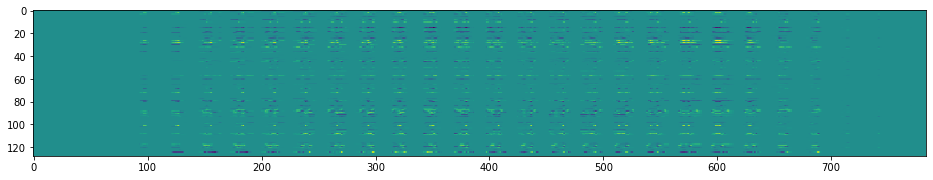

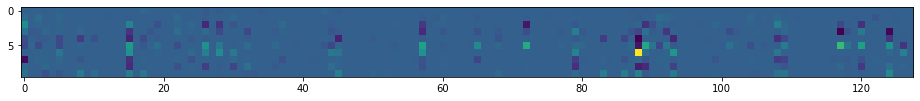

In [6]:
# compute gradients in torch
samp = [0,1,2,3]
# model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, img_rows * img_cols))).float().to(dev))
out.retain_grad()
loss = loss_function(out, torch.tensor(y_test[samp]).long().to(dev)).cpu().mean()
loss.retain_grad()
loss.backward()
plt.figure(figsize=(16,4))
plt.imshow(model.l1.weight.grad.cpu())
plt.figure(figsize=(16,4))
plt.imshow(model.l2.weight.grad.cpu())

In [7]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [9]:
# copy weights from pytorch, produce the same result?
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

# numpy forward pass
def forward(x):
  x = x.dot(l1)
  x = np.maximum(x, 0)
  x = x.dot(l2)  
  return x

def numpy_eval():
  y_test_preds_out = forward(X_test.reshape((-1, img_rows * img_cols)))
  y_test_preds = np.argmax(y_test_preds_out, axis=1)
  return (y_test == y_test_preds).mean()

numpy_eval()

0.9304

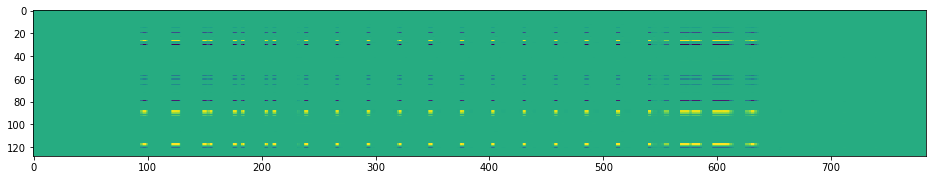

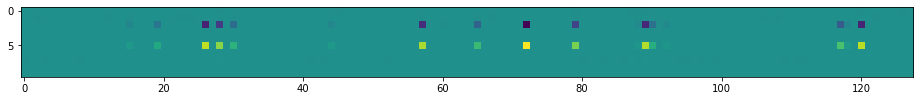

In [13]:
 # numpy forward and backward pass

def logsumexp(x):
  #return np.log(np.exp(x).sum(axis=1))
  # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
  c = x.max(axis=1)
  return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

def forward_backward(x, y):
  # training
  out = np.zeros((len(y),10), np.float32)
  out[range(out.shape[0]),y] = 1

  # forward pass
  x_l1 = x.dot(l1)
  x_relu = np.maximum(x_l1, 0)
  x_l2 = x_relu.dot(l2)
  x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
  x_loss = (-out * x_lsm).mean(axis=1)

  # training in numpy (super hard!)
  # backward pass

  # will involve x_lsm, x_l2, out, d_out and produce dx_sm
  d_out = -out / len(y)

  # derivative of logsoftmax
  # https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
  dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))

  # derivative of l2
  d_l2 = x_relu.T.dot(dx_lsm)
  dx_relu = dx_lsm.dot(l2.T)

  # derivative of relu
  dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

  # derivative of l1
  d_l1 = x.T.dot(dx_l1)
  
  return x_loss, x_l2, d_l1, d_l2

samp = [0,1,2,3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, img_rows * img_cols), y_test[samp])

plt.figure(figsize=(16,4))
plt.imshow(d_l1.T)
plt.figure(figsize=(16,4))
plt.imshow(d_l2.T)

loss 0.01 accuracy 0.98: 100%|██████████| 1000/1000 [00:02<00:00, 431.58it/s]


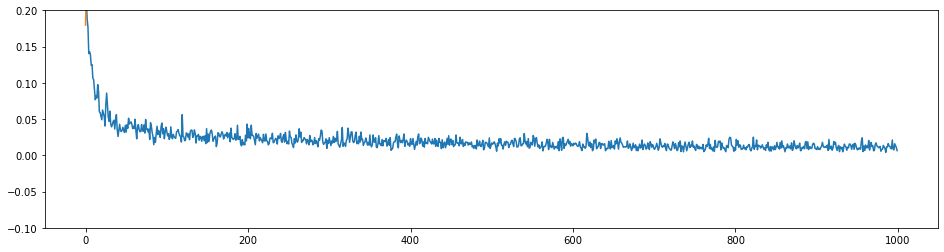

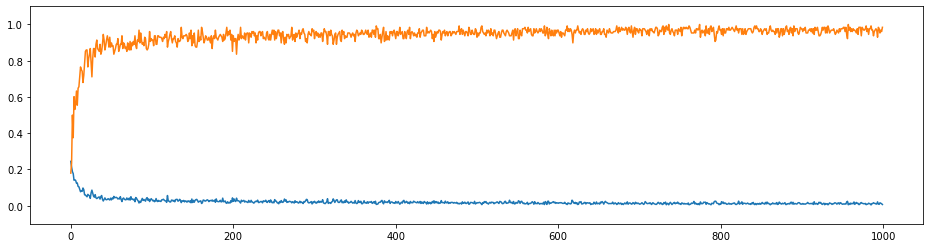

In [18]:
# numpy training
def layer_init(m, h):
  # gaussian is strong
  #ret = np.random.randn(m,h)/np.sqrt(m*h)
  # uniform is stronger
  ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
  return ret.astype(np.float32)

# reinit
np.random.seed(1337)
l1 = layer_init(img_rows * img_cols, batch_size)
l2 = layer_init(batch_size, num_classes)

lr = 0.001
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = X_train[samp].reshape((-1, img_rows * img_cols))
  Y = y_train[samp]
  x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
  
  cat = np.argmax(x_l2, axis=1)
  accuracy = (cat == Y).mean()
  
  # SGD
  l1 = l1 - lr*d_l1
  l2 = l2 - lr*d_l2
  
  loss = x_loss.mean()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.figure(figsize=(16,4))
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [6]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

# with tf.Session() as sess:
#     print (sess.run(c))

In [10]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: 


In [28]:
xtrain = X_train.astype('float32')
xtrain /= 255
xtrain

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.